# Mutual Information Minimization Demo

This demo is adapted from https://github.com/Linear95/CLUB

In this notebook, we provide a demo for how to use different MI estimators in `mi` folder to minimize mutual information with data under multivariate Gaussian setups. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

from mi import club, slice

## Dataset

Consider the following data generating process:

$\left[\begin{array}{c} x \\ y \end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{c} 0\\0\end{array}\right], \left[\begin{array}{cc} 1 &\rho \\ \rho & 1\end{array} \right] \right) $

Our goal is to minimise the parameter $\rho$ to minimize the mutual information $I(x, y)$ between $x$ and $y$ with samples $\mathcal{D}=  \{x^{(i)}, y^{(i)}\}^n_{i=1}$. NOte that this happens when $\rho = 0$. 

In order to optimise $\rho$, we consider parameterizing the covariance matrix by $\left[\begin{array}{cc} 1 &\rho \\ \rho & 1\end{array} \right] = {SS}^T$ with $S =\left[\begin{array}{cc} \cos \theta &\sin \theta \\ \sin \theta & \cos \theta \end{array} \right]$. Then we have $\left[\begin{array}{c} x \\ y \end{array}\right] = Sz, z \sim \mathcal{N}(z; 0, \mathbf{I})$. We can now instead optimise $\theta$.

In [8]:
class GaussianSampler(nn.Module):
    def __init__(self, dim=2, para_list = None):
        super(GaussianSampler, self).__init__()
        self.dim = dim
        if para_list is None:
            para_list = [0.55] * dim
        self.p_theta_ = torch.nn.Parameter(torch.tensor(para_list, requires_grad = True))
        
    def get_trans_mat(self):
        p_theta = self.p_theta_.cuda().unsqueeze(-1)

        trans_row1 = torch.cat((torch.sin(p_theta),torch.cos(p_theta)), dim=-1).unsqueeze(-1)
        trans_row2 = torch.cat((torch.cos(p_theta),torch.sin(p_theta)), dim=-1).unsqueeze(-1)  #[dim, 2,1]
        return torch.cat((trans_row1, trans_row2), dim=-1)  #[dim,2,2]

    def gen_samples(self, num_sample, cuda = True):
        noise= torch.randn(self.dim,num_sample,2).cuda()
        trans_mat = self.get_trans_mat()
        samples = torch.bmm(noise, trans_mat).transpose(0,1) #[dim, nsample, 2]
        if not cuda:
            samples = samples.cpu().detach().numpy()
        return samples[:,:,0], samples[:,:,1]

    def get_covariance(self):
        p_theta = self.p_theta_.cuda()
        return (2.*torch.sin(p_theta)*torch.cos(p_theta))

    def get_MI(self):
        rho = self.get_covariance()
        return -1./2.*torch.log(1-rho**2).sum().item()
    
sample_dim = 2
device = 'cuda:0'

We can plot the sample pairs of variable $x$ and $y$, which has a high linear correlation.

The corvariance of Gaussian is [0.8912074 0.8912074]


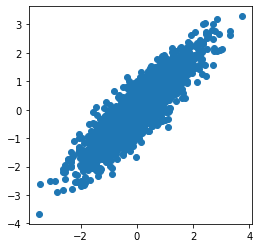

In [4]:
sampler = GaussianSampler(sample_dim).cuda()
print("The corvariance of Gaussian is {}".format(sampler.get_covariance().cpu().detach().numpy()))
x_sample, y_sample = sampler.gen_samples(1000, cuda = False)
plt.figure(figsize=(4, 4))
plt.scatter(x_sample, y_sample)
plt.show()

We may further apply an one-to-one mapping $g(\cdot)$ to $y$ to make the distributions $p(x, y)$ non-Gaussian (and hence a more challeging task). Note that this does not change MI: $I(x. g(y)) = I(x, y)$. Try different $g$ to see what happens.

In [7]:
def g1(y):    # linear mapping
    return y
    
def g2(y):    # z[0] = e(Ay), z[1] = tanh(Ay) 
    A = torch.Tensor([[1, 1.5], [1.5, 1]]).to(y.device)
    q = torch.matmul(y, A)
    z = torch.zeros(y.size()).to(y.device)
    z[:, 0] = q[:, 0].exp()
    z[:, 1] = torch.tanh(q[:, 1])
    return z

g = g2

## Slice 

Proposed method for minimising MI without estimating its value. See https://openreview.net/pdf?id=Ojakr9ofova

In [20]:
# hyperparams
hyperparams={}
hyperparams['bs'] = 200
hyperparams['lr'] = 1e-3
hyperparams['n_slice'] = 25


sampler = GaussianSampler(sample_dim).cuda()
sampler_optimizer = torch.optim.Adam(sampler.parameters(), lr = hyperparams['lr'])

mi_estimator = slice.SliceInfominLayer([sample_dim, hyperparams['n_slice'], sample_dim], hyperparams=hyperparams).to(device)

mi_true_values, mi_est_values, min_mi = [], [], 100.
for i in range(1500):
    sampler.train()
    mi_estimator.eval()
    x_samples, y_samples = sampler.gen_samples(hyperparams['bs'])
    
    # max-step (estimate sliced MI)
    xx_samples, yy_samples = sampler.gen_samples(5000)
    t0 = time.time()
    si_loss_train, si_loss_val = mi_estimator.learn(xx_samples, g(yy_samples))       
    t1 = time.time()
    
    # min-step (minimise sliced MI)
    sampler_loss = mi_estimator.objective_func(x_samples, g(y_samples))
    sampler_optimizer.zero_grad()
    sampler_loss.backward() 
    sampler_optimizer.step()

    mi_estimator.mode = 'eval'
    mi_true_values.append(sampler.get_MI())
    mi_est_values.append(si_loss_val)
    if i % 100 ==0:
        print("step {}, true MI value {}".format(i, sampler.get_MI()), 'est slice MI (in [0, 1])', si_loss_val, 'time used', t1-t0)

step 0, true MI value 1.573256492614746 est slice MI (in [0, 1]) 0.8807502388954163 time used 0.01385807991027832
step 100, true MI value 0.9228664636611938 est slice MI (in [0, 1]) 0.7651625275611877 time used 0.010928153991699219
step 200, true MI value 0.47025415301322937 est slice MI (in [0, 1]) 0.5878371596336365 time used 0.012984752655029297
step 300, true MI value 0.1818515956401825 est slice MI (in [0, 1]) 0.3883295953273773 time used 0.013120174407958984
step 400, true MI value 0.03544309735298157 est slice MI (in [0, 1]) 0.16607214510440826 time used 0.013036012649536133
step 500, true MI value 0.001285535516217351 est slice MI (in [0, 1]) 0.015233073383569717 time used 0.014239072799682617
step 600, true MI value 7.987408753251657e-05 est slice MI (in [0, 1]) 0.013376536779105663 time used 0.013609886169433594
step 700, true MI value 2.8104099328629673e-05 est slice MI (in [0, 1]) 0.02608567848801613 time used 0.013116598129272461
step 800, true MI value 5.2452269301284105e

### Visualise the learning dynamics

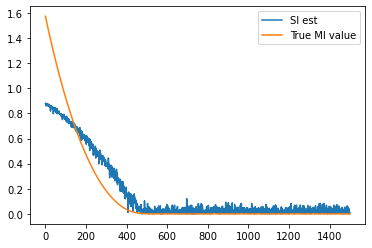

In [21]:
plt.plot(np.arange(len(mi_est_values)), mi_est_values, label='SI' + " est")
plt.plot(np.arange(len(mi_true_values)), mi_true_values, label="True MI value")
plt.legend()
plt.show()

### Visualise the optimised Gaussian sampler

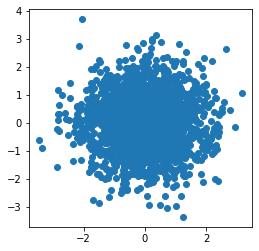

In [22]:
x_sample, y_sample = sampler.gen_samples(1000, cuda=False)
plt.figure(figsize=(4, 4))
plt.scatter(x_sample, y_sample)
plt.show()

one can see that there is no correlation between x and y. 

## CLUB

State-of-the-art method for minimising MI based on minmax learning and variational distribution. See https://arxiv.org/abs/2006.12013

In [11]:
# hyperparams
hyperparams={}
hyperparams['bs'] = 200
hyperparams['lr'] = 1e-3
hyperparams['inner_lr'] = 1e-3

sampler = GaussianSampler(sample_dim).cuda()
sampler_optimizer = torch.optim.Adam(sampler.parameters(), lr = hyperparams['lr'])

mi_estimator = club.ClubInfominLayer(dim_z=sample_dim, dim_y=sample_dim, hidden_size=100, hyperparams=hyperparams).to(device)
mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = hyperparams['inner_lr'])

mi_true_values, mi_est_values, min_mi = [], [], 100.
for i in range(1500):
    # sample a mini-batch
    sampler.train()
    mi_estimator.eval()
    x_samples, y_samples = sampler.gen_samples(hyperparams['bs'])
    
    # max-step (estimate MI)
    t0 = time.time()
    for j in range(5):                                                   
        mi_estimator.train()
        xx_samples, yy_samples = sampler.gen_samples(hyperparams['bs'])
        mi_estimator.mode = 'learn'
        mi_loss = -mi_estimator.objective_func(xx_samples, g(yy_samples))
        mi_optimizer.zero_grad()
        mi_loss.backward()
        mi_optimizer.step()
    t1 = time.time()
    
    # min-step (minimise MI)
    sampler_loss = mi_estimator(x_samples, g(y_samples))
    sampler_optimizer.zero_grad()
    sampler_loss.backward() # retain_graph=True)
    sampler_optimizer.step()

    mi_estimator.mode = 'eval'
    mi_true_values.append(sampler.get_MI())
    mi_est_values.append(mi_estimator(x_samples, y_samples).item())
    if i % 100 ==0:
        print("step {}, true MI value {}".format(i, sampler.get_MI()), 'est MI', mi_est_values[i], 'time used per inner loop', t1-t0)

step 0, true MI value 1.58111572265625 est MI -0.2938311696052551 time used 0.03813314437866211
step 100, true MI value 1.607811689376831 est MI 2.1924264430999756 time used 0.03473377227783203
step 200, true MI value 1.5978233814239502 est MI 2.203580617904663 time used 0.040142059326171875
step 300, true MI value 1.5823743343353271 est MI 2.599208354949951 time used 0.02826666831970215
step 400, true MI value 1.5420000553131104 est MI 1.9453437328338623 time used 0.03127479553222656
step 500, true MI value 1.513598084449768 est MI 1.8655853271484375 time used 0.0295870304107666
step 600, true MI value 1.4725697040557861 est MI 1.8858410120010376 time used 0.026993274688720703
step 700, true MI value 1.3835898637771606 est MI 2.0918049812316895 time used 0.029677867889404297
step 800, true MI value 1.344179391860962 est MI 1.9323382377624512 time used 0.0317537784576416
step 900, true MI value 1.2680182456970215 est MI 2.4965498447418213 time used 0.027118921279907227
step 1000, true 

### Visualising the learning dynamics

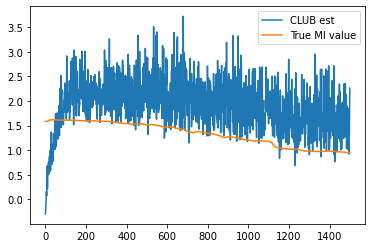

In [12]:
plt.plot(np.arange(len(mi_est_values)), mi_est_values, label='CLUB' + " est")
plt.plot(np.arange(len(mi_true_values)), mi_true_values, label="True MI value")
plt.legend()
plt.show()

### Visualise the optimised Gaussian sampler

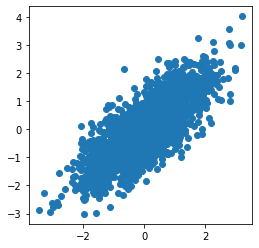

In [13]:
x_sample, y_sample = sampler.gen_samples(1000, cuda=False)
plt.figure(figsize=(4, 4))
plt.scatter(x_sample, y_sample)
plt.show()

The correlation between $x$ and $y$ is not well-penalised under g2 but is good under g1